In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


In [3]:
@jax.jit
def ternary_activation(x, thresholds):
    """
    Ternary activation function
    """
    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

@jax.jit
def ternary_stochastic(x, thresholds, noise_sd, key):
    key, key1 = jax.random.split(key, num = 2)
    noise = jax.random.normal(key1, shape = x.shape) * noise_sd

    x = x + noise

    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s


## helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)


In [4]:
@jax.custom_vjp
def ternary_with_grad(x, thresholds, noise_sd, key):
    return ternary_stochastic(x, thresholds, noise_sd, key)

def ternary_with_grad_fwd(x, thresholds, noise_sd, key):
    return ternary_with_grad(x, thresholds, noise_sd, key), (x, thresholds, noise_sd)

def ternary_with_grad_bwd(res, grads):
    x, thresholds, noise_sd = res
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad * grads, None, None, None)

ternary_with_grad.defvjp(ternary_with_grad_fwd, ternary_with_grad_bwd)


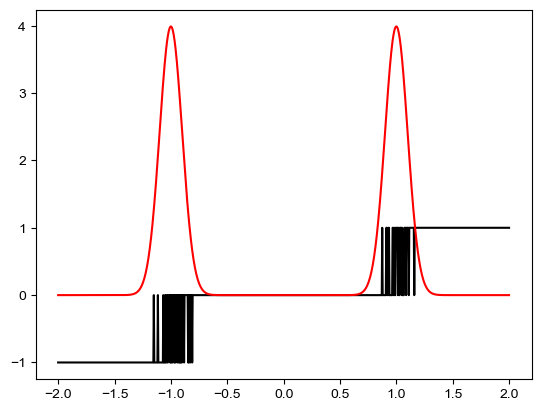

In [5]:
# check
t = np.linspace(-2, 2, 1000)
th = [-1., 1.]
nsd = 0.1
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, num = 1000)

act = jax.vmap(lambda x, k: ternary_with_grad(x, th, nsd, k))(t, keys)
# Compute gradients for each element using vmap with grad
grad_acts = jax.vmap(lambda x, k: jax.grad(lambda x_: ternary_with_grad(x_, th, nsd, k))(x))(t, keys)

plt.plot(t, act, '-k')
plt.plot(t, grad_acts, '-r')

Produce a drift in the weight matrix. For simplicity the noise comes from a uniform distribution

In [5]:
## initialize the vectors and ground truth weights
X = jax.random.randint(key = jax.random.key(0), shape = (100, 10), minval = -1, maxval = 2)
W_gt = jax.random.normal(shape = (100, 100), key = jax.random.key(0))
y_target = jnp.matmul(W_gt, X)
# print(y_target)

y_target_ter = jax.vmap(ternary_activation, in_axes = (0, None))(y_target, jnp.array([-1, 1]))
print(y_target_ter[:, 0])

[-1. -1.  1.  0. -1.  0. -1.  0.  1.  1.  1.  1. -1.  0.  1. -1. -1.  0.
  0.  1.  1.  1.  1. -1.  1.  1.  0.  1. -1. -1. -1.  0. -1. -1.  1. -1.
  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  0.
 -1.  1. -1.  1. -1.  1.  0.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1. -1.  1.  1. -1.  1.  0.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.]


In [6]:
## define the error matrix
error_mat = jax.random.uniform(key = jax.random.key(0), shape = (100, 100), minval = -0.05, maxval = 0.05)
W_err = W_gt * error_mat + W_gt

# print out the norm of error - ground truth matrix
print(f"Norm drift = {jnp.linalg.norm(W_err - W_gt)}")
# print(f"Norm of ground truth = {jnp.linalg.norm(W_gt - W_gt)}")

# test what y's this gives
y_err = jnp.matmul(W_err, X)
y_err = jax.vmap(ternary_activation, in_axes = (0, None))(y_err, jnp.array([-1, 1]))

print(f"Norm of target vector drift = {jnp.linalg.norm(y_err - y_target_ter)}")


Norm drift = 4.248536586761475
Norm of target vector drift = 5.916079998016357


In [7]:
print(X.shape, W_err.shape)
jnp.matmul(W_err, X)

(100, 10) (100, 100)


Array([[-2.51535511e+00,  8.99687958e+00, -4.62740898e+00,
        -7.64439523e-01,  1.61651077e+01,  1.78945236e+01,
         2.71356344e+00, -4.48022127e+00,  1.07578478e+01,
        -3.49790454e-02],
       [-9.79690552e+00, -7.94578648e+00,  2.01323814e+01,
        -1.06101694e+01,  1.84582710e+00, -7.44885826e+00,
        -1.35543518e+01, -3.33329058e+00,  9.85988855e-01,
        -5.59254074e+00],
       [ 1.72471771e+01, -1.08498335e+00, -8.44849396e+00,
        -2.68664598e-01, -1.25323362e+01,  1.85299325e+00,
         8.88212013e+00,  4.04702091e+00,  2.29887438e+00,
        -7.04797220e+00],
       [ 6.99825346e-01, -8.93173981e+00,  1.85088515e+00,
        -2.69946074e+00,  2.80266643e+00, -4.91904354e+00,
        -7.52446365e+00,  6.17221498e+00,  1.95167780e+00,
         5.15005887e-01],
       [-6.34631538e+00, -5.86424828e+00, -4.41578436e+00,
         8.67772198e+00,  4.40217257e+00,  3.66278887e+00,
        -1.43164742e+00, -8.65012550e+00, -1.73041093e+00,
        -3.

In [8]:
## define the loss function
def mse_loss(W, X, y_target_ternary, thresholds, noise_sd, key):
    y_pred = jnp.matmul(W, X)
    y_pred_ter = jax.vmap(ternary_with_grad, in_axes=(0, None, None, None))(y_pred, thresholds, noise_sd, key)
    return jnp.mean(jnp.square(y_pred_ter - y_target_ternary))

In [9]:
## loop and update
lr = 1e0
thr = [-1., 1.]
nsd = 1e-1
key = jax.random.PRNGKey(0)
num_steps = 5001
keys = jax.random.split(key, num = num_steps)
losses = []
w_norms = []
w_traj = defaultdict(jnp.array)


In [10]:
N_samples = int(16)
N_features = int(1000)
X = jax.random.randint(key = jax.random.key(0), shape = (N_samples, N_features), minval = -1, maxval = 2)
W_gt = jax.random.normal(shape = (N_samples, N_samples), key = jax.random.key(0))
y_target = jnp.matmul(W_gt, X)
# print(y_target)

y_target_ter = jax.vmap(ternary_activation, in_axes = (0, None))(y_target, jnp.array([-1, 1]))

## define the error matrix
error_mat = jax.random.uniform(key = jax.random.key(0), shape = (N_samples, N_samples), minval = -0.8, maxval = 0.8)
W_err = jax.random.normal(shape = (N_samples, N_samples), key = jax.random.key(1))#W_gt * error_mat + W_gt


In [11]:
for step in range(num_steps):
    
    key, subkey = jax.random.split(key)
    loss, loss_grad = jax.value_and_grad(mse_loss)(W_err, X, y_target_ter, thr, nsd, key)

    ## capture the weights every 500 steps
    if step%500 == 0:
        print(f"Step {step}, Loss = {loss}")
        w_traj[step] = W_gt - W_err
    

    W_err = W_err - lr * loss_grad

    # append losses and error norms
    w_norms.append(jnp.linalg.norm(W_err - W_gt)/jnp.linalg.norm(W_gt))

    losses.append(loss)


Step 0, Loss = 1.5440000295639038
Step 500, Loss = 0.06275000423192978
Step 1000, Loss = 0.018000001087784767
Step 1500, Loss = 0.017750000581145287
Step 2000, Loss = 0.015937501564621925
Step 2500, Loss = 0.018250001594424248
Step 3000, Loss = 0.017375001683831215
Step 3500, Loss = 0.01718750037252903
Step 4000, Loss = 0.016499999910593033
Step 4500, Loss = 0.017250001430511475
Step 5000, Loss = 0.016562500968575478


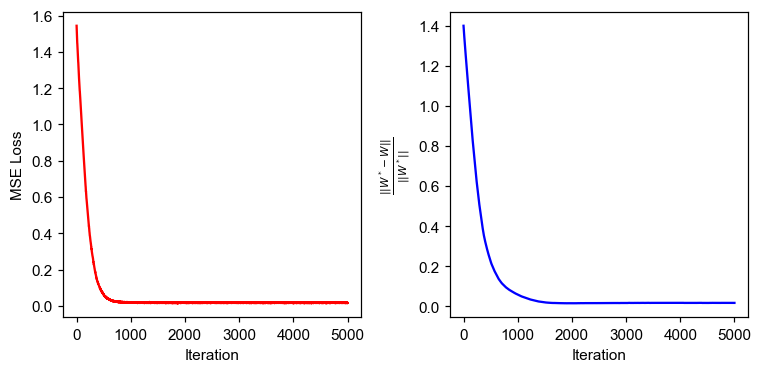

In [12]:
fig, ax = plt.subplots(1, 2, dpi = 110, figsize = (7, 3.5))
ax[0].plot(losses, '-r')
ax[1].plot(w_norms, '-b')

ax[0].set_xlabel('Iteration')

ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('MSE Loss')
ax[1].set_ylabel(r"$\frac{||W^* - W||}{||W^*||}$")


plt.tight_layout()

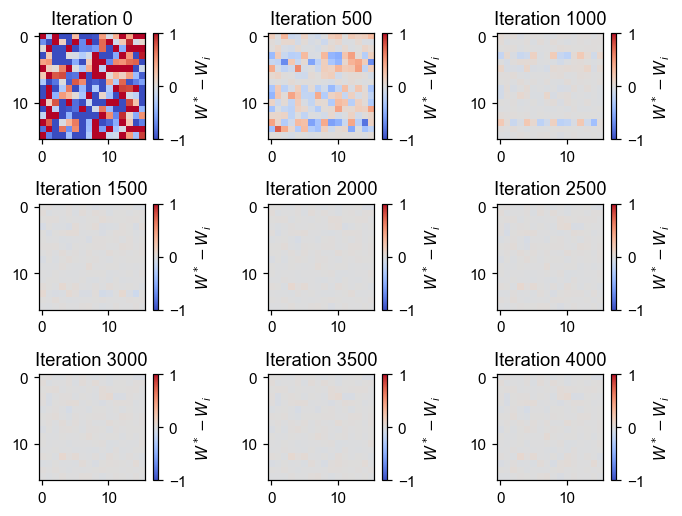

In [13]:
fig, ax = plt.subplots(3, 3, dpi = 110)

for axs, s in zip(ax.ravel(), w_traj.keys()):
    im = axs.imshow(w_traj[s], cmap = 'coolwarm', vmax = 1, vmin = -1)
    cbar = plt.colorbar(im, ax = axs)
    cbar.set_label(r'$W^* - W_i$')
    axs.set_title(f"Iteration {s}")

plt.tight_layout()

# Outer product update (old)

Define $X \in \mathbb{R}^{N \times M}$, $W \in \mathbb{R}^{N \times N}$ and $Y \in \mathbb{R}^{N \times M}$. Introduce errors in $W$ as

$$W \gets W + \xi$$

Generate outputs $\tilde{Y}$, each column of $\tilde{Y}$ is a new output vector.

Update the erights using the following procedure
$$e = (Y - \tilde{Y})$$

$$W \gets W - \eta x e^T$$

Here, $x$ is a column of $X$

In [24]:
key_op = jax.random.key(0)
N_samples = 16
N_features = 100
thr = jnp.array([-2., 2.])
X_op = jax.random.randint(key = key_op, shape = (N_samples, N_features), minval = -1., maxval = 2.)
W_gt_op = jax.random.normal(key = key_op, shape = (N_samples, N_samples))
Y_tar_op = jnp.matmul(W_gt_op, X_op)
Y_tar_op_ter = jax.vmap(ternary_activation, in_axes = (0, None))(Y_tar_op, thr)

print(Y_tar_op[:, 0])
print(Y_tar_op_ter[:, 0])

## introduce error
error_mat_op = jax.random.uniform(key = key_op, shape = (N_samples, N_samples), minval = -0.5, maxval = 0.5)
W_err_op = W_gt_op * error_mat_op + W_gt_op
# W_err_op = jax.random.normal(key = key_op, shape = (N_samples, N_samples))

print(f"Norm of difference between weights = {jnp.linalg.norm(W_err_op - W_gt_op)}")

print(f"W dim = {W_gt_op.shape}, X dim = {X_op.shape}, Y_tar dim = {Y_tar_op_ter.shape}")

[-3.3096619  -0.23879284  3.0035763   2.0131583  -0.16596618 -3.7653263
 -5.164553   -0.3471164   2.986709    1.0784634   2.41768    -0.3628118
 -2.9505768  -4.443352    0.00988454 -2.112473  ]
[-1.  0.  1.  1.  0. -1. -1.  0.  1.  0.  1.  0. -1. -1.  0. -1.]
Norm of difference between weights = 6.6060590744018555
W dim = (16, 16), X dim = (16, 100), Y_tar dim = (16, 100)


In [30]:
num_steps = 3000
lr = 1e-5
wt_norms = []
y_norms = []
y_dist = []
e_norm = []

for step in tqdm(range(num_steps)):
    wt_norms.append(jnp.linalg.norm(W_err_op - W_gt_op)) # append the norm of difference
    Y_pred = jnp.matmul(W_err_op, X_op)
    Y_pred_ter = jax.vmap(ternary_activation, in_axes = (0, None))(Y_pred, thr)
    e_norm.append(jnp.linalg.norm(Y_pred_ter - Y_tar_op_ter))
    
    for i in range(X_op.shape[1]):

        # extract the column of X
        x_col = X_op[:, i]

        # multiply the column with the weight matrix
        y_pred = jnp.matmul(W_err_op, x_col)

        # ternarize the output
        y_pred = ternary_activation(y_pred, thr) #ternary_stochastic(x=y_pred, thresholds=thr, noise_sd=0.1, key=key_op)

        # compute the error
        y_tar_col = Y_tar_op_ter[:, i]
        e = y_tar_col - y_pred

        # find the update matrix
        dw = jnp.outer(x_col, e) #jnp.matmul(x_col, e.T)

        # update the weight matrix
        W_err_op = W_err_op + lr * dw






  0%|          | 0/3000 [00:00<?, ?it/s]

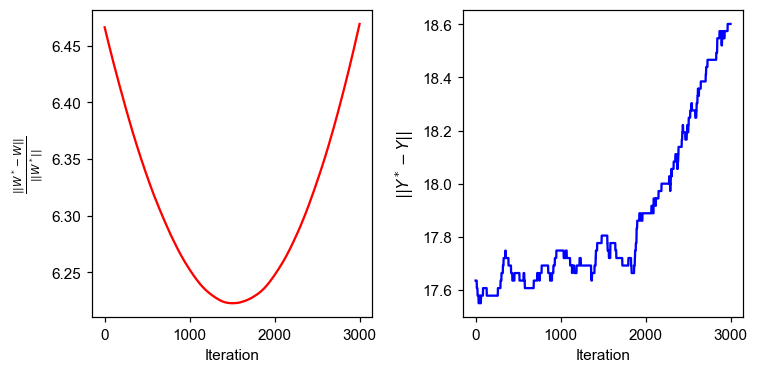

In [31]:
fig, ax = plt.subplots(1, 2, dpi = 110, figsize = (7, 3.5))
ax[0].plot(wt_norms, '-r')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r"$\frac{||W^* - W||}{||W^*||}$")

ax[1].plot(e_norm, '-b')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r"$||Y^* - Y||$")

plt.tight_layout()

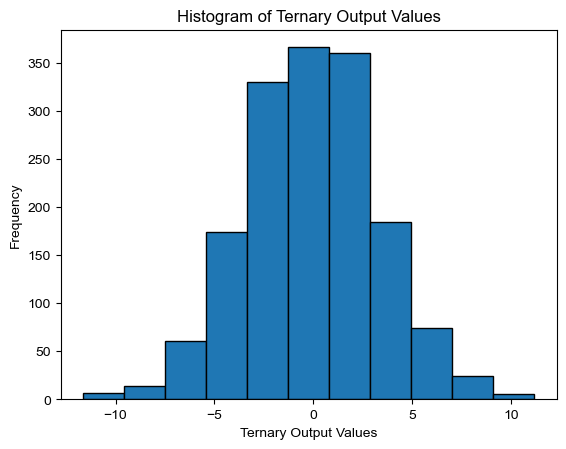

In [32]:
y_dist = Y_pred.flatten()
plt.hist(y_dist, bins=11, edgecolor='k')
plt.xlabel('Ternary Output Values')
plt.ylabel('Frequency')
plt.title('Histogram of Ternary Output Values')
plt.show()

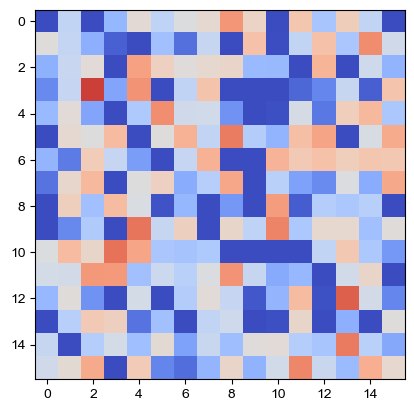

In [33]:
plt.imshow(W_gt_op - W_err_op, cmap = 'coolwarm', vmax = 0.5, vmin = -0.5)

In [476]:
aa = jnp.matmul(x_col, e.T)
print(aa.shape)
print(aa)

bb = jnp.outer(x_col, e)
print(bb.shape)

()
2.0
(16, 16)


# Outer Product (new)

#### General Algorithm

Receive $W^* \in \mathbb{R}^{N \times N}$ (target weights), $X \in \mathbb{\{-1, 0, +1\}}^{N \times M}$ is a matrix of random vectors. The columns are each random vectors of size $N$

1. Obtain $Y = WX$, $Y \in \mathbb{R}^{N \times M}$. $Y$ contains $M$ columns corresponding to a mapping of the corresponding column in $X$.
2. Threshold $Y$ to get $Y^* \in \mathbb{\{-1, 0, +1\}}^{N \times M}$.
3. Introduce a drift $\Delta W \sim \mathcal{U}(-\alpha, +\alpha)$ where $\alpha$ can be a small-ish deviation. $\Delta W \in \mathbb{R}^{N \times N}$
4. Then obtain the drifted weights $W_d \gets W^* + \Delta W$.
5. Receive a learning rate $\eta$
6. Iterate over number of steps:
   1. for i < num_steps:
      1. Compute $Y_p = W_d X$
      2. Compute the error $e = Y^* - Y_p$. Store the error
      3. for $x$ in columns of $X$:
         1. Compute $y_p = W_d x$
         2. Extract corresponding column in $Y^* = y^*$
         3. Compute $e = y^* - y_p$
         4. Compute $dW = x \otimes e$
         5. Update the weights $W_d \gets W_d + \eta dw$


In [6]:
@jax.jit
def bipolar_activation(x, threshold):
    return jnp.where(x > threshold, 1.0, -1.0)

## define a one hot function
@jax.jit
def one_hot_max_columnwise(matrix):
    """
    Converts each column of a matrix to a one-hot encoded vector using JAX.
    
    Args:
        matrix (jnp.ndarray): Input matrix of shape (rows, cols).
        
    Returns:
        jnp.ndarray: One-hot encoded matrix of shape (rows, cols).
    """
    def one_hot_max_column(vector):
        max_index = jnp.argmax(vector)  # Find the index of the maximum element
        return jax.nn.one_hot(max_index, len(vector))  # Create a one-hot vector

    # Use vmap to apply the function to each column of the matrix
    return jax.vmap(one_hot_max_column, in_axes=1, out_axes=1)(matrix)

@jax.jit
def one_hot_vec(vector):
    max_index = jnp.argmax(vector)
    return jax.nn.one_hot(max_index, len(vector))

## testing
vv = jax.random.normal(key = jax.random.key(0), shape = (3, 3))
print(vv)
print(one_hot_max_columnwise(vv))

v = jax.random.normal(key = jax.random.key(16), shape = (3,))
print(v)
print(one_hot_vec(v))

[[-0.3721109   0.26423115 -0.18252768]
 [-0.7368197   0.44973662 -0.1521442 ]
 [-0.67135346 -0.5908641   0.73168886]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[-0.44089547  1.3165504   0.7389697 ]
[0. 1. 0.]


W shape = (16, 16)
X shape = (16, 1000)
Y shape = (16, 1000)


Text(0.5, 1.0, '$W_d$')

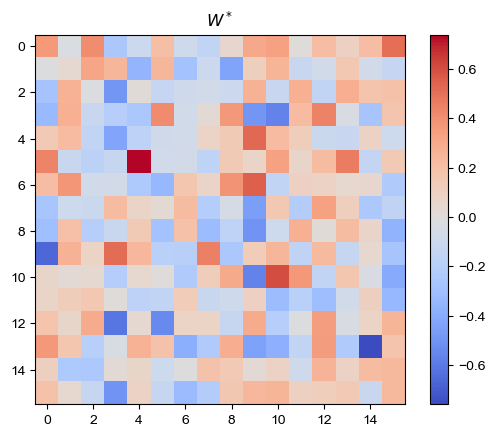

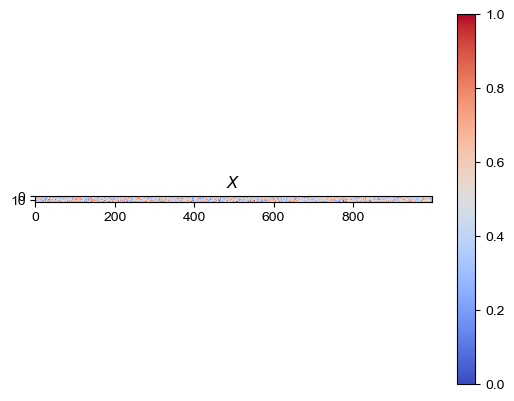

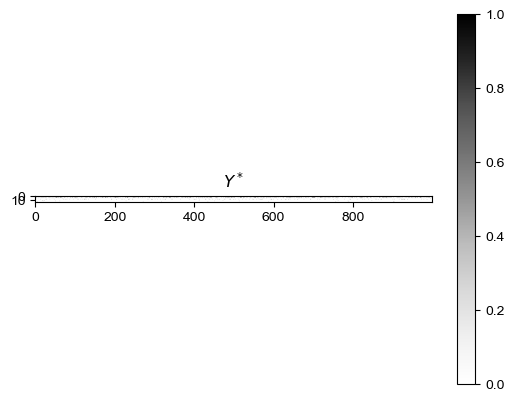

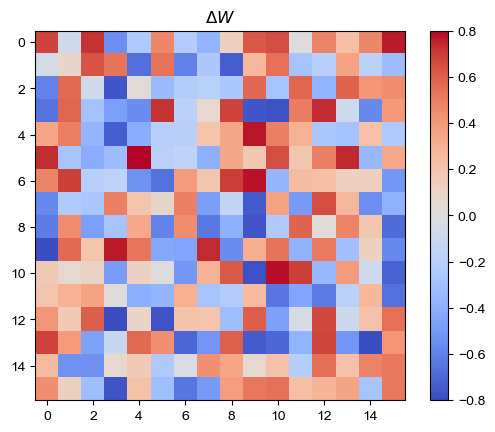

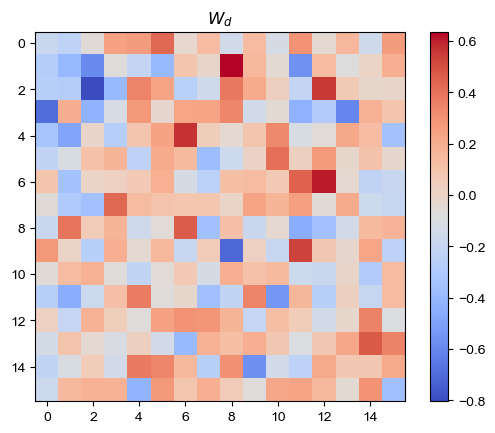

In [28]:
# define weights
key = jax.random.key(0)
thresholds = [-.5, .5]
threshold = 0.0
n_vectors = 1000
vector_size = 16
W_tar = jax.random.normal(key = key, shape = (vector_size, vector_size))*jnp.sqrt(1/vector_size) # let's see if this initialization helps!
print(f"W shape = {W_tar.shape}")
X_vecs = jax.random.randint(key = key, shape = (vector_size, n_vectors), minval = 0, maxval = 2)
print(f"X shape = {X_vecs.shape}")
Y_tar = one_hot_max_columnwise(jnp.matmul(W_tar, X_vecs))#jax.vmap(bipolar_activation, in_axes = (0, None))(jnp.matmul(W_tar, X_vecs), threshold)
print(f"Y shape = {Y_tar.shape}")

plt.figure()
i1 = plt.imshow(W_tar, cmap = 'coolwarm', vmax = jnp.max(W_tar), vmin = jnp.min(W_tar))
plt.colorbar(i1)
plt.title(r"$W^*$")

plt.figure()
i1 = plt.imshow(X_vecs, cmap = 'coolwarm')
plt.colorbar(i1)
plt.title(r"$X$")

plt.figure()
i2 = plt.imshow(Y_tar, cmap = 'Greys')
plt.colorbar(i2)
plt.title(r"$Y^*$")

## define a drift matrix
alpha = 0.8
perc_drift = jax.random.uniform(key = key, shape = (vector_size, vector_size), minval = -alpha, maxval = alpha)
key, key2 = jax.random.split(key)
W_drift = jax.random.normal(key = key, shape=(vector_size, vector_size)) * (1/jnp.sqrt(vector_size))#W_tar + W_tar * perc_drift

plt.figure()
i3 = plt.imshow(perc_drift, cmap = 'coolwarm', vmax = alpha, vmin = -alpha)
plt.colorbar(i3)
plt.title(r"$\Delta W$")

plt.figure()
i4 = plt.imshow(W_drift, cmap = 'coolwarm', vmax = jnp.max(W_drift), vmin = jnp.min(W_drift))
plt.colorbar(i4)
plt.title(r"$W_d$")

In [29]:
y_errors = []
w_errors = []
num_steps = 501
lr = 1e-4

for step in tqdm(range(num_steps)):
    Y_pred = jax.vmap(ternary_activation, in_axes = (0, None))(jnp.matmul(W_drift, X_vecs), thresholds)
    y_errors.append(jnp.linalg.norm(Y_pred - Y_tar))
    w_errors.append(jnp.linalg.norm(W_drift - W_tar))

    for i in range(X_vecs.shape[1]):
        # if i > 0:
        #     break

        x_col = X_vecs[:, i]
        # print(f"X_col: {x_col}")

        y_pred = jnp.matmul(W_drift, x_col)
        y_pred = one_hot_vec(y_pred)
        # print(f"Prediction: {y_pred}")

        #y_pred = ternary_activation(y_pred, thresholds)

        y_pred_tar = Y_tar[:, i]
        # print(f"Target: {y_pred_tar}")

        e = y_pred_tar - y_pred
        # print(f"Error: {e}")

        dw = jnp.outer(x_col, e)
        # print(f"dw = {dw}")

        W_drift = W_drift + lr * dw.T

# plt.figure()
# plt.plot(y_errors, '-r', label = 'Y Error')
# plt.plot(w_errors, '-b', label = 'W Error')
# plt.xlabel('Iteration')
# plt.ylabel('Error')
# plt.legend()

  0%|          | 0/501 [00:00<?, ?it/s]

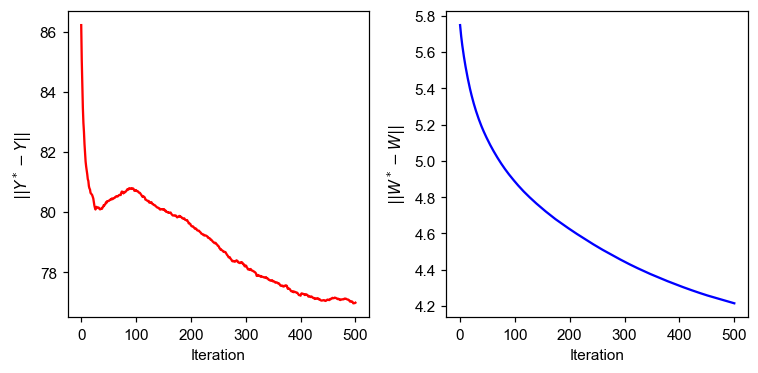

In [30]:
fig, ax = plt.subplots(1, 2, dpi = 110, figsize = (7, 3.5))
ax[0].plot(y_errors, '-r')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r"$||Y^* - Y||$")
ax[1].plot(w_errors, '-b')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r"$||W^* - W||$")

plt.tight_layout()

In [139]:
y_pred

Array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)